# This project uses the TMDB 5000 Movie Dataset from Kaggle: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

warnings.filterwarnings('ignore')

In [2]:
movies = pd.read_csv("C:/Users/ayana/Downloads/Movie Recommendation System/tmdb_5000_movies.csv")
credits = pd.read_csv("C:/Users/ayana/Downloads/Movie Recommendation System/tmdb_5000_credits.csv")

In [3]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [4]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
movies = movies.merge(credits, left_on='id', right_on='movie_id', how='left')

In [6]:
movies = movies[['id', 'title_x', 'genres', 'keywords', 'crew']]
movies.rename(columns={'title_x': 'title'},inplace=True)

In [7]:
movies.isnull().sum()

id          0
title       0
genres      0
keywords    0
crew        0
dtype: int64

In [8]:
def parse_json_column(x):
    if pd.isna(x):
        return []
    return [i['name'] for i in ast.literal_eval(x)][:5]  

movies['genres'] = movies['genres'].apply(parse_json_column)
movies['keywords'] = movies['keywords'].apply(parse_json_column)


In [9]:
def get_director(x):
    if pd.isna(x):
        return ''
    for i in ast.literal_eval(x):
        if i['job'] == 'Director':
            return i['name']
    return ''

movies['director'] = movies['crew'].apply(get_director)

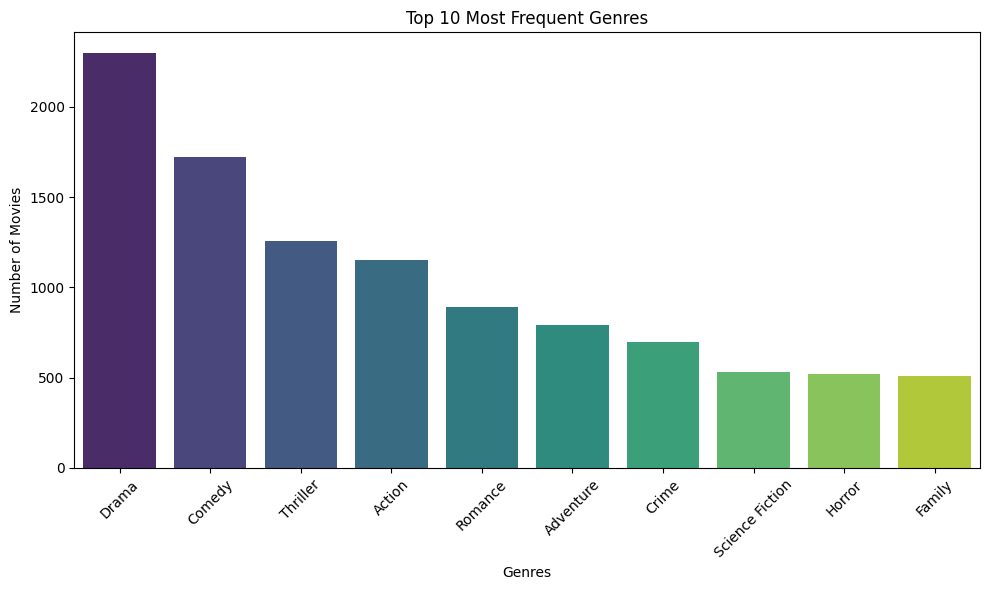

In [10]:
all_genres = [genre for sublist in movies['genres'] for genre in sublist]
genre_counts = Counter(all_genres).most_common(10)  

plt.figure(figsize=(10, 6))
sns.barplot(x=[g[0] for g in genre_counts], y=[g[1] for g in genre_counts], palette='viridis')
plt.title('Top 10 Most Frequent Genres')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

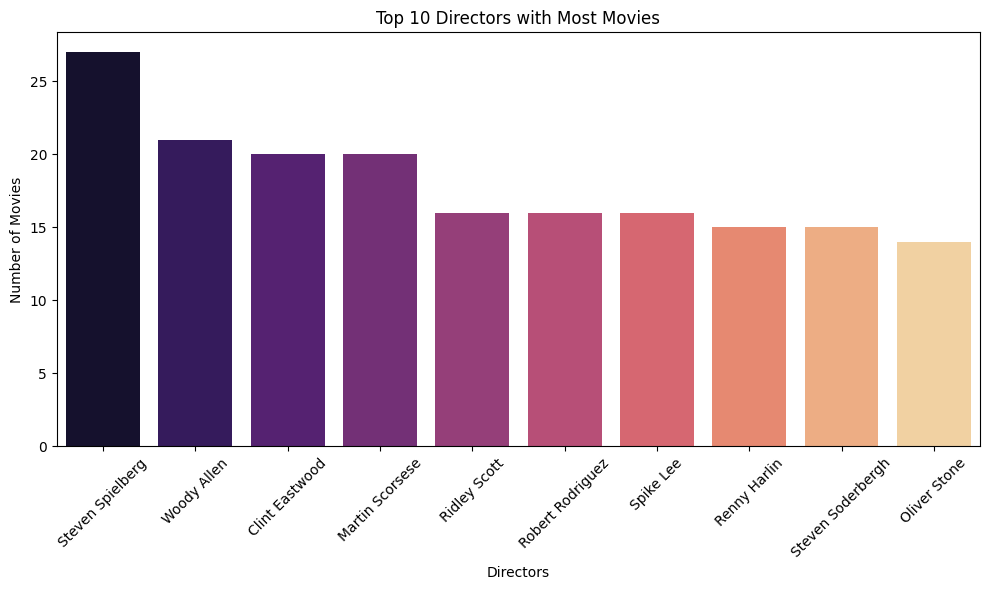

In [11]:
director_counts = movies['director'].value_counts()[1:11]  
plt.figure(figsize=(10, 6))
sns.barplot(x=director_counts.index, y=director_counts.values, palette='magma')
plt.title('Top 10 Directors with Most Movies')
plt.xlabel('Directors')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

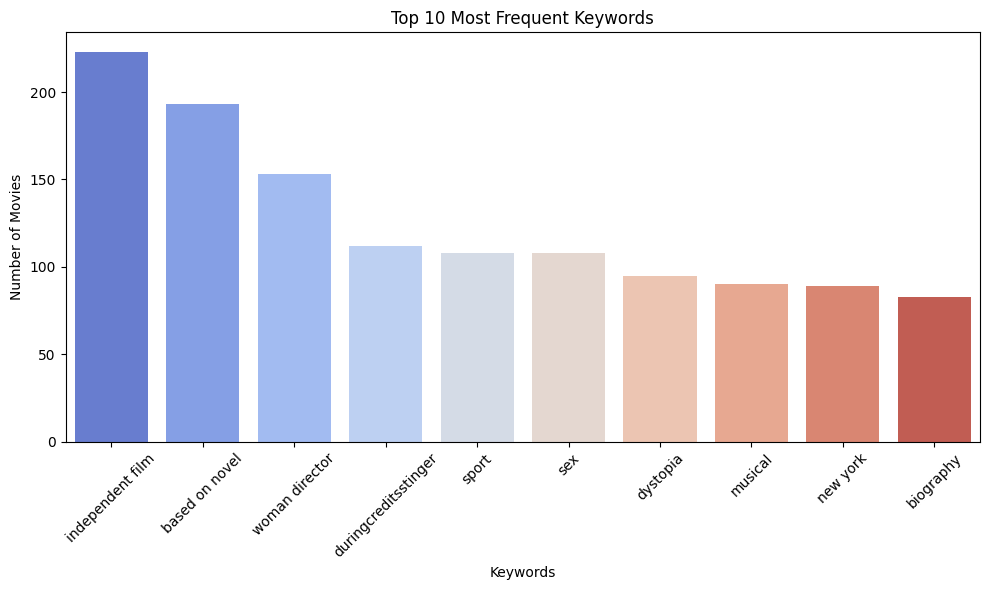

In [12]:
all_keywords = [kw for sublist in movies['keywords'] for kw in sublist]
keyword_counts = Counter(all_keywords).most_common(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=[k[0] for k in keyword_counts], y=[k[1] for k in keyword_counts], palette='coolwarm')
plt.title('Top 10 Most Frequent Keywords')
plt.xlabel('Keywords')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
def create_content(row):
    genres = ' '.join(row['genres']) * 2  
    keywords = ' '.join(row['keywords']) * 2 
    director = row['director'] * 5  
    return f"{genres} {keywords} {director}"

movies['content'] = movies.apply(create_content, axis=1)


In [14]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(movies['content'])

In [15]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [16]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6] 
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices], [i[1] for i in sim_scores]

In [17]:
movie_to_test = 'Inception'
recommended_movies, sim_scores = get_recommendations(movie_to_test)

print(f"\nRecommendations for '{movie_to_test}':")
print(recommended_movies)


Recommendations for 'Inception':
3573            Memento
1033           Insomnia
1196       The Prestige
65      The Dark Knight
95         Interstellar
Name: title, dtype: object


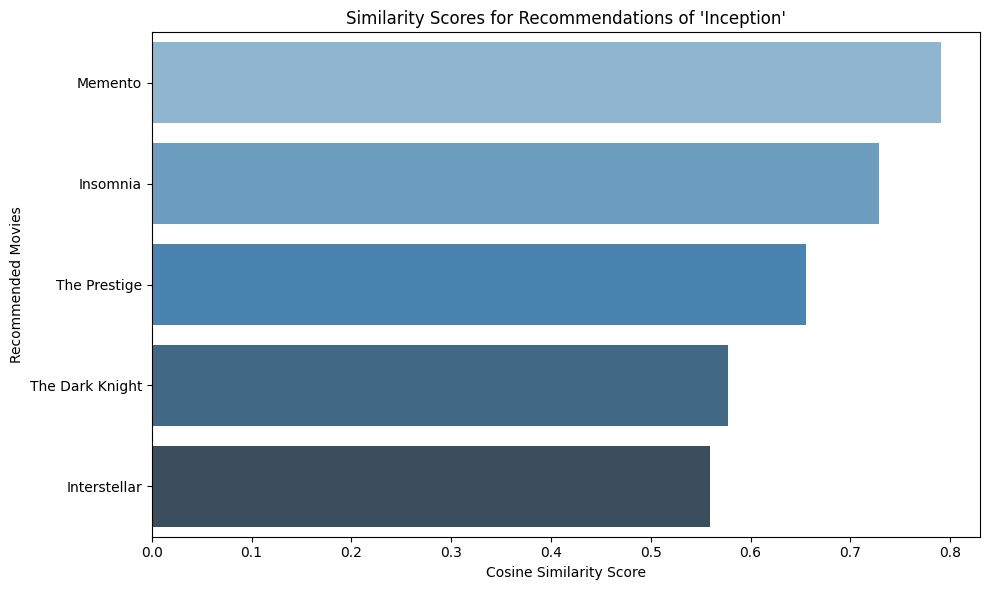

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x=sim_scores, y=recommended_movies, palette='Blues_d')
plt.title(f"Similarity Scores for Recommendations of '{movie_to_test}'")
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Recommended Movies')
plt.tight_layout()
plt.show()

In [19]:
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(cosine_sim, 'cosine_sim.pkl')
movies[['id', 'title', 'content']].to_pickle('movies_data.pkl')

print("\nModel and data saved successfully!")


Model and data saved successfully!
